In [1]:
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 256
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("R",zenith=0*60*math.pi/180/3600,azimuth=0*math.pi/4,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
GMT = ceo.GMT_MX(D,nPx)
wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

162.0
44.0
76.0


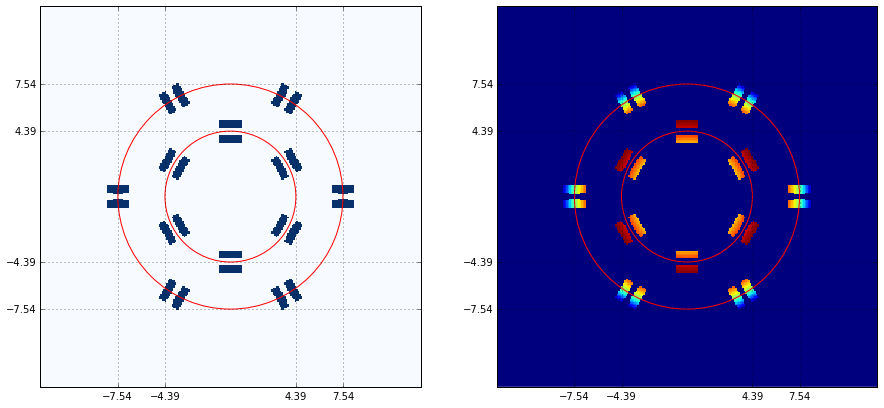

In [10]:
print np.ceil(nPx*16/D)
rc = 4.387
rp = 7.543
rc_px = np.round(nPx*rc/D)
print rc_px
rp_px = np.round(nPx*rp/D)
print rp_px
L = 1.5
A = np.zeros((nPx,nPx))
P = np.zeros((nPx,nPx))
images = []
Ms = []
for k in range(6):
    theta = -k*math.pi/3
    M = ceo.Mask(nPx,L,i_s=128+rc_px,j_s=128,n_s=np.ceil(nPx*L/D),theta=theta)
    Ms.append(M)
    src.reset()
    GMT.propagate(src)
    src.masked(M)
    A += src.wavefront.amplitude.host(shape=(nPx,nPx))
    P += src.wavefront.phase.host(shape=(nPx,nPx),units='nm')
    wfs.reset()
    wfs.propagate(src)
    images.append(wfs.frame.host())
for k in range(6):
    theta = (1-k)*math.pi/3
    M = ceo.Mask(nPx,L,i_s=128,j_s=128+rp_px,n_s=np.ceil(nPx*L/D),theta=theta)
    Ms.append(M)
    src.reset()
    GMT.propagate(src)
    src.masked(M)
    A += src.wavefront.amplitude.host(shape=(nPx,nPx))
    P += src.wavefront.phase.host(shape=(nPx,nPx),units='nm')
    wfs.reset()
    wfs.propagate(src)
    images.append(wfs.frame.host())
R = D/2
fig,(ax1,ax2) =subplots(ncols=2)
fig.set_size_inches((15,10))
ax1.imshow(A,extent=[-R,R,-R,R],interpolation='None',cmap='Blues',origin='lower')
ax1.grid()
ax1.set_xticks([-rp,-rc,rc,rp])
ax1.set_yticks([-rp,-rc,rc,rp])
yticks([-rp,-rc,rc,rp])
c1 = Circle((0,0),radius=rc, color='r', fill=False)
ax1.add_patch(c1)
c2 = Circle((0,0),radius=rp, color='r', fill=False)
ax1.add_patch(c2)
h2 = ax2.imshow(P,extent=[-R,R,-R,R],interpolation='None',origin='lower')
ax2.grid()
xticks([-rp,-rc,rc,rp])
yticks([-rp,-rc,rc,rp])
c1 = Circle((0,0),radius=rc, color='r', fill=False)
ax2.add_patch(c1)
c2 = Circle((0,0),radius=rp, color='r', fill=False)
ax2.add_patch(c2)
#colorbar(h2,ax=ax2)

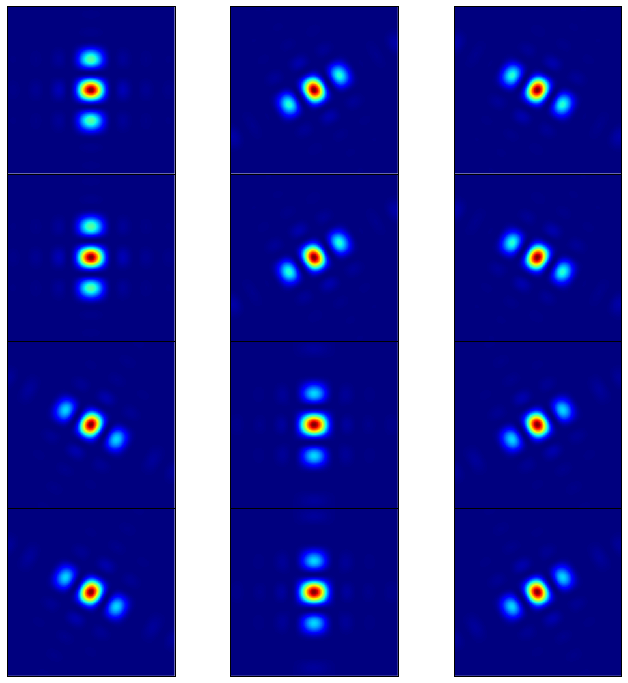

In [4]:
fig = figure()
fig.set_size_inches((12,12))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.0, hspace=0.0)
for k in range(12):
    ax = plt.Subplot(fig, gs[k])
    ax.imshow((images[k]),interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

<matplotlib.colorbar.Colorbar instance at 0x2aefd97afc68>

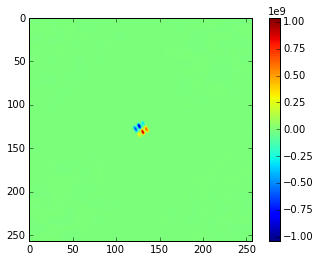

In [5]:
from numpy.fft import fft2, fftshift
I = [fftshift(fft2(fftshift(images[k]))) for k in range(12)]
imshow(np.imag(I[1]))
colorbar()

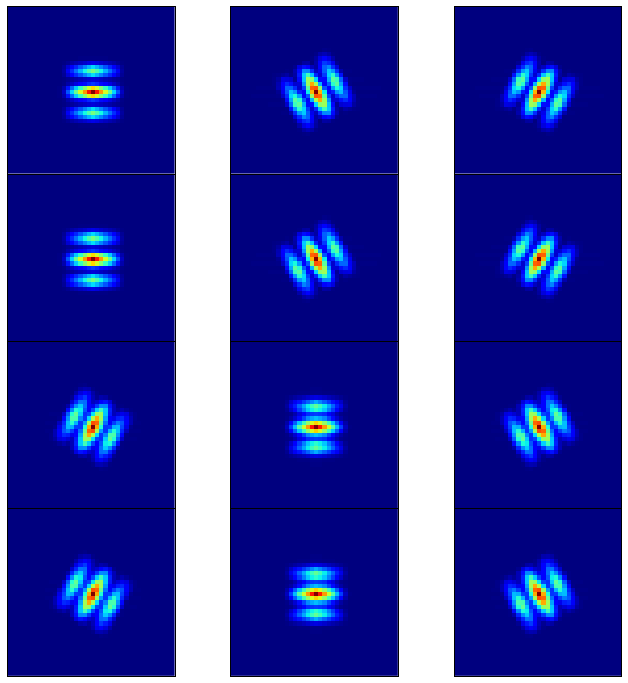

In [6]:
fig = figure()
fig.set_size_inches((12,12))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.0, hspace=0.0)
for k in range(12):
    ax = plt.Subplot(fig, gs[k])
    ax.imshow(np.abs(I[k][128-20:128+20,128-20:128+20]),interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

In [8]:
PM = src.rays.piston_mask[0]

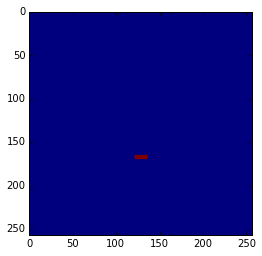

In [9]:
M = Ms[0]
cuPM = ceo.cuFloatArray(host_data=PM[6,:])
M.alter(cuPM)
pa = M.f.host(shape=(nPx,nPx))
imshow(pa)

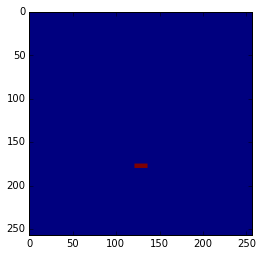

In [11]:
M = Ms[0]
cuPM = ceo.cuFloatArray(host_data=PM[0,:])
M.alter(cuPM)
pb = M.f.host(shape=(nPx,nPx))
imshow(pb)

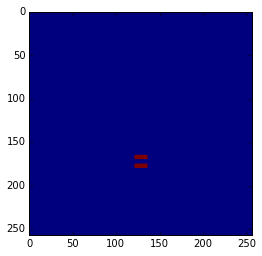

In [12]:
imshow(pa+pb)

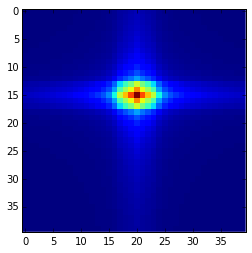

In [39]:
F_pa = fft2(fftshift(pa),(2*nPx,2*nPx))
F_pb = fft2(fftshift(pb),(2*nPx,2*nPx))
G = fftshift(ifft2(F_pa*np.conj(F_pb),(nPx,nPx)))
imshow(np.abs(G[128-20:128+20,128-20:128+20]),interpolation='none')

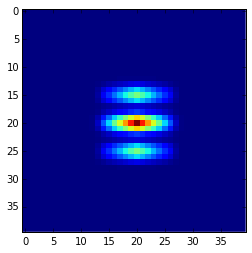

In [40]:
imshow(np.abs(I[0][128-20:128+20,128-20:128+20]),interpolation='none')

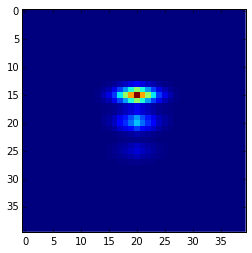

In [41]:
Q = G*I[0]
imshow(np.abs(Q[128-20:128+20,128-20:128+20]),interpolation='none')

-840.376034836


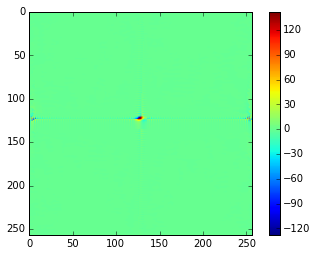

In [43]:
A = np.arctan2(np.real(Q),np.imag(Q))
imshow(np.abs(G)*A)
colorbar()
print np.sum(A)

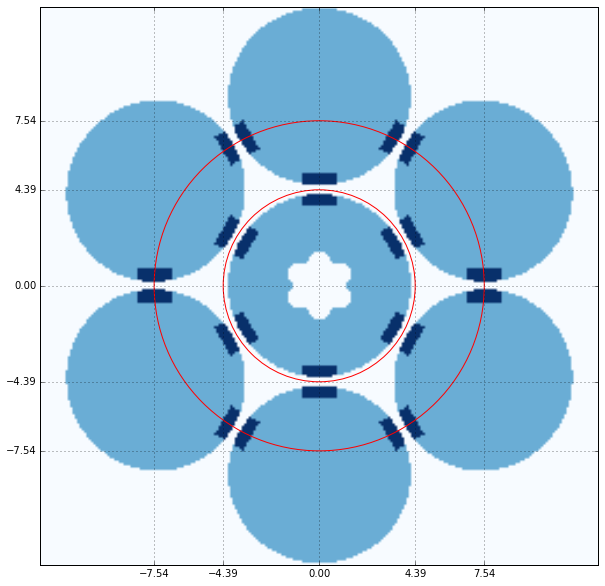

In [22]:
fig,ax =subplots()
fig.set_size_inches((10,10))
P = M1.piston_mask.sum(axis=0)
optical_system(src)
P = src.wavefront.amplitude.host().flatten()
ax.imshow(P.reshape(nPx,nPx) + np.logical_and(P,M.sum(axis=0)).reshape(nPx,nPx),
          extent=[-R,R,-R,R],interpolation=None,cmap='Blues',origin='lower')
grid()
xticks([-rp,-rc,0,rc,rp])
yticks([-rp,-rc,0,rc,rp])
c1 = Circle((0,0),radius=rc, color='r', fill=False)
ax.add_patch(c1)
c2 = Circle((0,0),radius=rp, color='r', fill=False)
ax.add_patch(c2)

In [12]:
src.wavefront.piston(mask=M1.piston_mask)*1e9

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [13]:
P = M1.piston_mask
P.shape

(7, 58081)

In [14]:
P[1,:].shape

(58081,)

In [15]:
M.shape

(12, 58081)

In [16]:
W = (P * np.array([arange(1,8)]).T**2).sum(axis=0)

<matplotlib.colorbar.Colorbar instance at 0x2b9706a83b90>

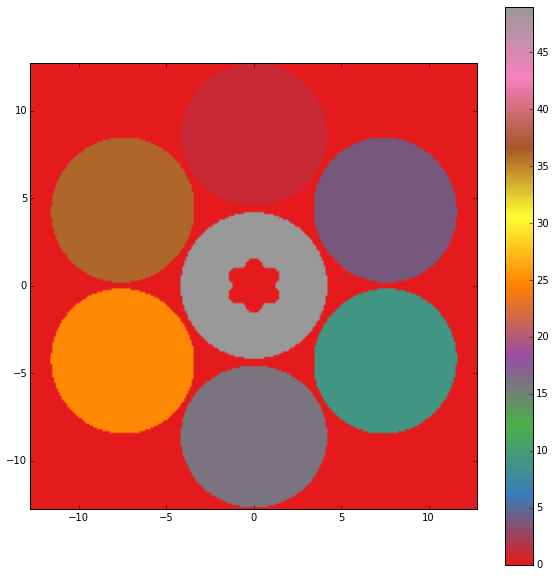

In [17]:
fig, ax =subplots()
fig.set_size_inches((10,10))
h = ax.imshow(W.reshape(nPx,nPx),extent=[-R,R,-R,R],interpolation=None,cmap='Set1',origin='lower')
colorbar(h)

<matplotlib.colorbar.Colorbar instance at 0x2b9706c879e0>

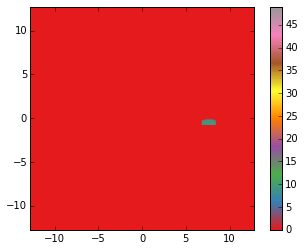

In [18]:
imshow((W*P[2,:]*M[7,:]).reshape(nPx,nPx),
       extent=[-R,R,-R,R],interpolation=None,cmap='Set1',clim=[0,49],origin='lower')
colorbar()

In [19]:
(W*P[0,:]*M[0,:]).shape

(58081,)

In [20]:
(W*P[6,:]*M[0,:]).T.shape

(58081,)

In [ ]:
print np.sum( W*P[0,:]*M[0,:] )/np.sum( P[0,:]*M[0,:] ) - np.sum( W*P[6,:]*M[0,:] )/np.sum( P[6,:]*M[0,:] )
print np.sum( W*P[0,:]*M[6,:] )/np.sum( P[0,:]*M[6,:] ) - np.sum( W*P[1,:]*M[6,:] )/np.sum( P[1,:]*M[6,:] )

In [ ]:
print np.sum( W*P[1,:]*M[1,:] )/np.sum( P[1,:]*M[1,:] ) - np.sum( W*P[6,:]*M[1,:] )/np.sum( P[6,:]*M[1,:] )
print np.sum( W*P[1,:]*M[6,:] )/np.sum( P[1,:]*M[6,:] ) - np.sum( W*P[2,:]*M[7,:] )/np.sum( P[2,:]*M[7,:] )

In [ ]:
for k in range(6):
    print k,(k+1)%6
    print np.sum( W*P[k,:]*M[k,:] )/np.sum( P[k,:]*M[k,:] ) - \
        np.sum( W*P[6,:]*M[k,:] )/np.sum( P[6,:]*M[k,:] )
    print np.sum( W*P[k,:]*M[k+6,:] )/np.sum( P[k,:]*M[k+6,:] ) - \
        np.sum( W*P[(k+1)%6,:]*M[k+6,:] )/np.sum( P[(k+1)%6,:]*M[k+6,:] )

In [ ]:
print range(7)
print np.roll(np.array(range(7)),1)

In [ ]:
for k in range(6):
    print np.sum( W*P[k,:]*M[k,:] )/np.sum( P[k,:]*M[k,:] ) - \
        np.sum( W*P[6,:]*M[k,:] )/np.sum( P[6,:]*M[k,:] )
    print np.sum( W*P[k,:]*M[k+6,:] )/np.sum( P[k,:]*M[k+6,:] ) - \
        np.sum( W*np.roll(P,-2,axis=0)[k,:]*M[k+6,:] )/np.sum( np.roll(P,-2,axis=0)[k,:]*M[k+6,:] )

In [ ]:
k = 5

In [ ]:
np.sum( W*P[0,:]*M[11,:] )/np.sum( P[0,:]*M[k+6,:] )

In [ ]:
np.sum( P[0,:]*M[11,:] )

In [ ]:
np.sum( np.roll(P,-2,axis=0)[5,:]*M[11,:] )

In [ ]:
plot(P[0,:],'.')
plot(np.roll(P,1,axis=0)[5,:])

In [ ]:
P.shape

In [ ]:
print a[0:15]

In [ ]:
a = np.random.normal(size=(4,3))
print a

In [ ]:
print roll(a,-1,axis=0)

In [ ]:
P.shape

In [ ]:
print P